In [97]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.sandbox.stats.multicomp import multipletests 
from itertools import combinations

In [98]:
data = pd.read_csv('churn_analysis.csv', index_col=0)
data['churn'] = data['churn'].map({'False.': 0, 'True.': 1})
data_t1 = data[data['treatment'] == 1]
data.shape

(3333, 22)

In [108]:
p1 = []

for state1, state2 in combinations(data_t1['state'].unique(), 2):
    vc = data_t1[(data_t1['state'] == state1) |
                 (data_t1['state'] == state2)].groupby(['state']) \
                                              .agg({'churn': [lambda x: (x == 0).sum(), 'sum']}) \
                                              .values
    p1.append(scipy.stats.chi2_contingency(vc, correction=False)[1])

In [109]:
np.sum(np.array(p1) < 0.05)

34

---

In [104]:
p2 = []

for state1, state2 in combinations(data_t1['state'].unique(), 2):
    vc = data_t1[(data_t1['state'] == state1) |
                 (data_t1['state'] == state2)].groupby(['state']) \
                                              .agg({'churn': [lambda x: (x == 0).sum(), 'sum']}) \
                                              .values
    p2.append(scipy.stats.chi2_contingency(vc, correction=True)[1])

In [105]:
np.sum(np.array(p2) < 0.05)

0

In [110]:
(np.array(p1) < np.array(p2)).all()

False

In [111]:
np.mean(p1), np.mean(p2)

(0.5018273798739158, 0.6640566382051047)

---

In [112]:
p3 = []

for state1, state2 in combinations(data_t1['state'].unique(), 2):
    vc = data_t1[(data_t1['state'] == state1) |
                 (data_t1['state'] == state2)].groupby(['state']) \
                                              .agg({'churn': [lambda x: (x == 0).sum(), 'sum']}) \
                                              .values
    p3.append(scipy.stats.fisher_exact(vc)[1])

In [113]:
np.mean(p1), np.mean(p2), np.mean(p3)

(0.5018273798739158, 0.6640566382051047, 0.6483383060020681)

---

In [75]:
scipy.stats.pearsonr(data['day_calls'], data['mes_estim'])

(-0.05179435058757264, 0.0027798836869738384)

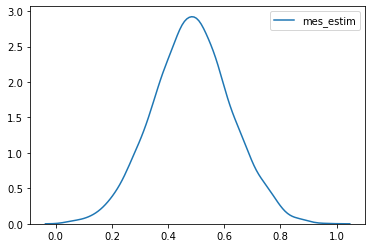

In [76]:
sns.kdeplot(data['mes_estim'])

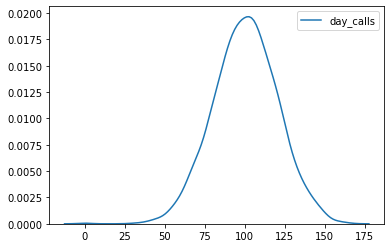

In [77]:
sns.kdeplot(data['day_calls'])

---

In [78]:
scipy.stats.spearmanr(data['day_calls'], data['mes_estim'])

SpearmanrResult(correlation=0.043349880533927444, pvalue=0.012317367189170541)

---

In [116]:
conf_table = np.empty((data_t1['state'].unique().shape[0], 2))
for i, s in enumerate(data_t1['state'].unique()):
    conf_table[i, 0] = (data_t1[data_t1['state'] == s]['churn'] == 0).sum()
    conf_table[i, 1] = (data_t1[data_t1['state'] == s]['churn'] == 1).sum()
conf_table

array([[18.,  7.],
       [22.,  2.],
       [15.,  0.],
       [13.,  2.],
       [18.,  5.],
       [17.,  5.],
       [20.,  2.],
       [17.,  4.],
       [19.,  2.],
       [19.,  1.],
       [17.,  7.],
       [20.,  4.],
       [11.,  5.],
       [17.,  5.],
       [20.,  3.],
       [19.,  2.],
       [20.,  3.],
       [14.,  6.],
       [18.,  1.],
       [27.,  6.],
       [18.,  3.],
       [17.,  2.],
       [20.,  4.],
       [18.,  4.],
       [20.,  8.],
       [16.,  2.],
       [18.,  2.],
       [18.,  6.],
       [16.,  7.],
       [27.,  5.],
       [10.,  2.],
       [20.,  3.],
       [27.,  2.],
       [21.,  4.],
       [22.,  4.],
       [14.,  4.],
       [18.,  4.],
       [16.,  1.],
       [11.,  2.],
       [21.,  3.],
       [25.,  5.],
       [22.,  2.],
       [10.,  5.],
       [16.,  3.],
       [19.,  5.],
       [11.,  1.],
       [25.,  5.],
       [11.,  1.],
       [21.,  3.],
       [12.,  1.],
       [16.,  5.]])

In [117]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

print('V Крамера статистика: %.4f' % cramers_stat(conf_table))

V Крамера статистика: 0.2004


---

In [92]:
data_con = data[data['treatment'] == 1]['churn'].values
data_t0 = data[data['treatment'] == 0]['churn'].values
data_t2 = data[data['treatment'] == 2]['churn'].values

In [119]:
p = []
p.append(stats.mannwhitneyu(data_con, data_t0).pvalue)
p.append(stats.mannwhitneyu(data_con, data_t2).pvalue)

In [121]:
reject, p_corrected, a1, a2 = multipletests(p, 
                                            alpha = 0.05, 
                                            method = 'holm') 

In [123]:
p_corrected

array([0.1142279 , 0.00936569])

In [124]:
reject

array([False,  True])

In [125]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [128]:
p_1 = []
p_1.append(proportions_diff_z_test(proportions_diff_z_stat_ind(data_con, data_t0)))
p_1.append(proportions_diff_z_test(proportions_diff_z_stat_ind(data_con, data_t2)))

In [130]:
reject, p_corrected, a1, a2 = multipletests(p_1, 
                                            alpha = 0.05, 
                                            method = 'holm') 

In [131]:
p_corrected

array([0.22833116, 0.01869617])